# Bitcoin Time Series Analysis
Does the report include a section describing the data?
Does the report include a paragraph detailing the main objective(s) of this analysis?  
Does the report include a section with variations of a Time Series, Survival Analysis, or Deep Learning model and specifies which one is the model that best suits the main objective(s) of this analysis?
Does the report include a clear and well presented section with key findings related to the main objective(s) of the analysis?
Does the report highlight possible flaws in the model and a plan of action to revisit this analysis with additional data or different modeling techniques? 

## Data Description

CSV files for select bitcoin exchanges for the time period of Jan 2012 to December March 2021, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. Timestamps are in Unix time. Timestamps without any trades or activity have their data fields filled with NaNs. If a timestamp is missing, or if there are jumps, this may be because the exchange (or its API) was down, the exchange (or its API) did not exist, or some other unforeseen technical error in data reporting or gathering.
https://www.kaggle.com/mczielinski/bitcoin-historical-data/metadata


* Timestamp: Start time of time window (60s window), in Unix time
* Open: Open price at start time window
* High: High price within time window
* Low: Low price within time window
* Close :Close price at end of time window
* Volume_(BTC): Volume of BTC transacted in this window
* Volume_(Currency):Volume of corresponding currency transacted in this window
* Weighted_Price: VWAP- Volume Weighted Average Price ,The VWAP Index is obtained taking the sum of all the prices, multiplied by the volume of the trade and then divided by the entire volume.

## Objectives 
The objective of this project is to compare Neural Networks and ARIMA modeling to find which model is better to predict Bitcoin price.
First we will get an EDA(Explanatory Data Analysis)to better understand the data to find some trends or seasonality then we will train and fit some models to find which does better predictions.
For this comparison we will focus only on the weighted price  

In [1]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os
# ignore warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
plotsize = (13, 5)

In [2]:
#Importing CSV 
df_Bitcoin= pd.read_csv('data/inter_bitcoin.csv')
#df_Bitcoin=df_Bitcoin.interpolate().to_csv('data/inter_bitcoin.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'data/inter_bitcoin.csv'

In [ ]:
df_Bitcoin2=df_Bitcoin[df_Bitcoin['Volume_(BTC)'].isna()==True]
df_Bitcoin2

# EDA Explanatory Data Analysis
At first sight of this dataset we see that data is in a format that is not easy to interpret so first thing first we change it to a more comprehensive format like DD/MM/YYYY:HHMM


In [ ]:
date_time=df_Bitcoin.Timestamp.apply(lambda x: pd.datetime.fromtimestamp(x))   #Timestamp date_time conversion
date_time
df_Bitcoin['Timestamp']= date_time


Now the timestamp is converted to a simplier format. Part of the preparation task is to set the timestamp as index. Then we fill the nan values with 0

In [ ]:
df_Bitcoin=df_Bitcoin.set_index('Timestamp')
df_Bitcoin=df_Bitcoin[(365*5):]
df_Bitcoin=df_Bitcoin.dropna()

In [ ]:
df_Bitcoin

In [ ]:
df_Bitcoin['Open']

In [ ]:
df_Bitcoin_daily=df_Bitcoin.resample('D').mean() # Data resampling by date
# Resampling to monthly frequency
df_Bitcoin_month = df_Bitcoin.resample('M').mean()
# Resampling to annual frequency
df_Bitcoin_year = df_Bitcoin.resample('A-DEC').mean()


# Resampling to quarterly frequency
df_Bitcoin_yearQ = df_Bitcoin.resample('Q-DEC').mean()



In [ ]:
# PLOTS

fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_Bitcoin_daily.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_Bitcoin_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Bitcoin_yearQ.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_Bitcoin_year.Weighted_Price, '-', label='By Years')
plt.legend()

In [ ]:
import statsmodels.api as sm
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_Bitcoin_yearQ.Weighted_Price,model='additive').plot()
sm.tsa.seasonal_decompose(df_Bitcoin_year.Weighted_Price).plot()
sm.tsa.seasonal_decompose(df_Bitcoin_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_Bitcoin_month.Weighted_Price)[0])
plt.show()

From this plot is possible to identify some trends but and a monthly and Q4 seasonality
We will focus on monthly seasonality

In [ ]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

In [ ]:
# run DFT on monthly
dftest(df_Bitcoin_month.Weighted_Price)
# p-value allows us to not reject a unit root: data is not stationary

In [ ]:
sm.tsa.graphics.plot_acf(df_Bitcoin_month['Weighted_Price'],zero=False)
sm.tsa.graphics.plot_pacf(df_Bitcoin_month['Weighted_Price'],zero=False);

## Selecting the correct model 
Now using the pmdarima library , using  a train set of our dataset we can get the best ARIMA model.


In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(df_Bitcoin_month.Weighted_Price, start_p=0, start_q=0,
                           max_p=30, max_q=30, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
auto_model.summary()  #To visualize all the stats of the model 

Now we fit the model with test set 

In [ ]:
auto_model.fit(df_Bitcoin_month.Weighted_Price)
auto_model.plot_diagnostics(lags=12)

Using this given model we can get a prediction and then comparing with actual values

In [ ]:

mydates = pd.date_range('2021-03-31', '2032-02-28',freq='M').to_list()
mydates

preds1,conf=auto_model.predict(n_periods=len(mydates),return_conf_int=True)
preds1=pd.DataFrame(preds1,index=mydates,columns=['Predictions'])
#conf=pd.DataFrame(conf,index=mydates, columns=['Confidence'])
p_val=auto_model.pvalues()
res=auto_model.resid()
plt.plot(res)

In [ ]:
df_Bitcoin_month.Weighted_Price.plot(label='original', color='red')
preds1.Predictions.plot(label='predicted', color='teal')
plt.legend(loc='best')
plt.show()

# Time Series Prediciton With LSTM



In [314]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [315]:
price = df_Bitcoin_month.Weighted_Price
size = int(len(price) * 0.7)

train_df, test_df = price[0:size], price[size:len(price)]
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

# Scale the data using minMaxScaler
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
# assign training values
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [316]:
# creates model
model = Sequential()
model.add(LSTM(10,input_shape = (None,1), activation="relu", return_sequences=True))
model.add(Dense(1))

In [317]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [318]:
# fit the model to the training data
model.fit(x_train,y_train,epochs=300,batch_size=32)


Epoch 1/300
3/3 [==============================] - 2s 3ms/step - loss: 0.0488
Epoch 2/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0479
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.0470
Epoch 4/300
3/3 [==============================] - 0s 14ms/step - loss: 0.0462
Epoch 5/300
3/3 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 6/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0445
Epoch 7/300
3/3 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 8/300
3/3 [==============================] - 0s 6ms/step - loss: 0.0431
Epoch 9/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0425
Epoch 10/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0419
Epoch 11/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0412
Epoch 12/300
3/3 [==============================] - 0s 15ms/step - loss: 0.0407
Epoch 13/300
3/3 [==============================] - 0s 4ms/

In [319]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = np.reshape(predicted_price, (len(predicted_price), 1))
predicted_price = scaler.inverse_transform(predicted_price)

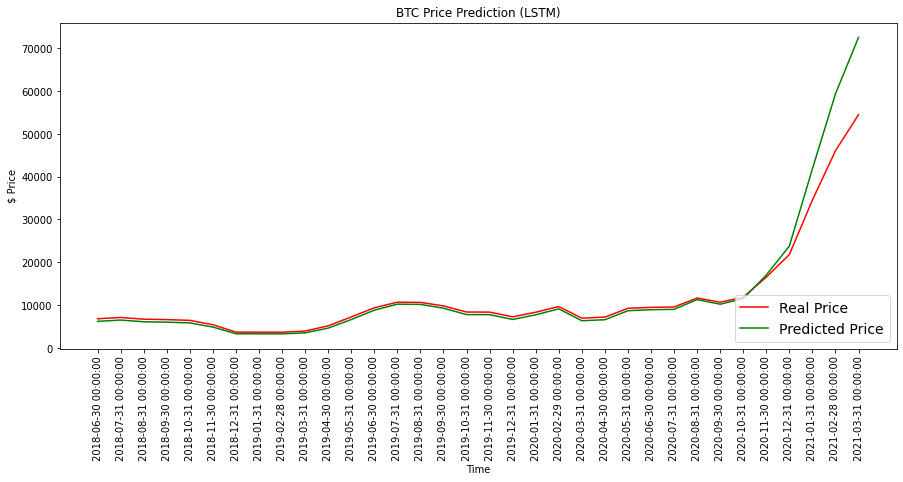

In [320]:
# plotting the results
plt.figure(figsize=(15, 6))
ax = plt.gca()  
plt.plot(test_df.values, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction (LSTM)')
test_df = test_df.reset_index()
x= test_df.index
labels = test_df['Timestamp']
plt.xticks(x, labels, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel('$ Price')
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [321]:
rmse = np.sqrt(mean_squared_error(test_df.Weighted_Price.values, predicted_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4092.013
